# Notebook 09 — Encerramento do Capítulo 02

Neste notebook, vamos fechar o cap02 conectando **tokenização via BPE** com o treinamento de **embeddings via CBoW (Continuous Bag of Words)**.

Pipeline:
1. Treinar um **BPE tokenizer** (Byte Pair Encoding) a partir de um corpus.
2. Usar os **tokens/subtokens do BPE** para gerar pares (contexto → alvo) do CBoW.
3. Treinar um modelo CBoW simples para aprender embeddings dos tokens.


![Pipeline](../../imagens/09_pipeline_preprocessamento.png)

In [1]:
import random
import re
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter, defaultdict
from collections.abc import Iterable
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Verificação da presença de GPU / device

In [2]:
print(torch.__version__)  # Versão do torch
print(torch.cuda.is_available())  # Verificação de GPU
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

2.5.1+cu121
True
NVIDIA GeForce RTX 4050 Laptop GPU
Usando: cuda


## Fixando o seed para reproducibilidade

In [3]:
def set_seed(seed: int = 42) -> None:
    """
    Fixa seeds para reprodutibilidade em Python, NumPy e PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Garante determinismo (pode afetar performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(123)

## Função auxiliar: plot de embeddings (redução para 2D internamente)

In [4]:
def plot_embeddings(
    embeddings_2d: dict[str, torch.Tensor | np.ndarray | list[float]],
    highlight: list[str] = None,
    figsize: tuple = (8, 8),
) -> None:
    """
    Plota embeddings 2D de palavras em um gráfico cartesiano.

    Parâmetros:
    ----------
    embeddings_2d : Dict[str, array-like]
        Dicionário palavra -> vetor 2D.
    highlight : List[str], optional
        Lista de palavras a serem destacadas no gráfico.
    figsize : tuple, default = (8, 8)
        Tamanho da figura.
    """
    if highlight is None:
        highlight = []

    plt.figure(figsize=figsize)

    for palavra, vetor in embeddings_2d.items():
        # Converte para numpy
        if isinstance(vetor, torch.Tensor):
            vetor = vetor.detach().cpu().numpy()
        else:
            vetor = np.array(vetor)

        x, y = vetor[0], vetor[1]

        if palavra in highlight:
            plt.scatter(x, y, s=120)
            plt.text(x + 0.02, y + 0.02, palavra, fontsize=12, weight="bold")
        else:
            plt.scatter(x, y, s=40, alpha=0.7)
            plt.text(x + 0.02, y + 0.02, palavra, fontsize=9)

    # Linhas dos eixos
    plt.axhline(0)
    plt.axvline(0)

    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    plt.title("Visualização dos Embeddings (2D)")
    plt.grid(True)
    plt.show()

## 1) BPE tokenizer (Byte Pair Encoding)

Abaixo está a implementação didática do BPE (copiada do notebook **04 - BPE tokenizer**).

In [5]:
@dataclass
class BPEResult:
    """Armazena resultados do treinamento do BPE (didático)."""

    vocab: dict[tuple[str, ...], int]
    merges: list[tuple[str, str]]
    token_to_id: dict[str, int]
    id_to_token: dict[int, str]


class BytePairEncoderDecoder:
    """
    Byte Pair Encoding (BPE) do zero, com passo a passo (didático).

    Ideia central (BPE clássico para subpalavras):
    - Representamos cada palavra como caracteres + marcador de fim de palavra (</w>)
    - Contamos pares adjacentes mais frequentes (bigramas de símbolos)
    - Iterativamente "fundimos" (merge) o par mais frequente em um novo símbolo
    - Guardamos a sequência de merges para tokenizar (encode) textos novos

    Observação:
    - Este é o BPE "clássico" baseado em palavras, suficiente para entender o mecanismo.
    - Em tokenizadores modernos (ex.: GPT-2), há detalhes adicionais (bytes, etc.),
      mas o coração do BPE (aprender merges frequentes) é o mesmo.
    BPE do zero (didático) **considerando pontuação**.

    Ajustes principais desta versão:
    - A tokenização inicial separa: palavras e pontuação ([,.!?;:])
    - Pontuação vira "tokens atômicos" (não recebem </w>)
    - Palavras recebem caracteres + </w> (fim de palavra), como no BPE clássico
    - O decode reconstrói o texto:
        * remove </w> e repõe espaços corretamente
        * NÃO coloca espaço antes de pontuação
    """

    def __init__(self, end_of_word: str = "</w>") -> None:
        if not isinstance(end_of_word, str) or not end_of_word:
            raise ValueError("`end_of_word` deve ser uma string não vazia.")
        self.end_of_word = end_of_word

        self.merges: list[tuple[str, str]] = []
        self.token_to_id: dict[str, int] = {}
        self.id_to_token: dict[int, str] = {}

        # Pontuação suportada (didático e suficiente pro seu exemplo)
        self._punct = {".", ",", "!", "?", ";", ":"}

    # ======================================================
    # 1) Tokenização: palavras + pontuação
    # ======================================================
    def _basic_tokenize_with_punct(self, text: str) -> list[str]:
        """
        Separa palavras e pontuação.

        Ex.: "O gato sobe no tapete." -> ["O", "gato", "sobe", "no", "tapete", "."]
        """
        if not isinstance(text, str):
            raise TypeError("O parâmetro `text` deve ser uma string.")
        if not text.strip():
            return []

        # Palavras (com acentos) OU pontuação isolada
        return re.findall(r"[A-Za-zÀ-ÿ0-9]+|[,.!?;:]", text)

    def _token_to_symbols(self, token: str) -> tuple[str, ...]:
        """
        Converte um token em símbolos para o BPE:
        - Se for pontuação: retorna (token,)
        - Se for palavra: retorna (c1, c2, ..., </w>)
        """
        if token in self._punct:
            return (token,)
        return tuple(list(token) + [self.end_of_word])

    # ======================================================
    # 2) Construção do vocab inicial (com pontuação)
    # ======================================================
    def build_initial_vocab(
        self, corpus: Iterable[str], verbose: bool = True
    ) -> dict[tuple[str, ...], int]:
        if corpus is None:
            raise TypeError("`corpus` não pode ser None.")

        corpus = list(corpus)
        if not corpus:
            raise ValueError("`corpus` precisa conter ao menos 1 frase/texto.")

        vocab: dict[tuple[str, ...], int] = defaultdict(int)

        if verbose:
            print("=== PASSO 1: Corpus bruto ===")
            for i, line in enumerate(corpus, start=1):
                print(f"{i}. {line}")
            print()

        if verbose:
            print("=== PASSO 2: Tokenização (palavras + pontuação) ===")

        all_tokens: list[str] = []
        for line in corpus:
            toks = self._basic_tokenize_with_punct(line)
            all_tokens.extend(toks)

        if verbose:
            print("Tokens extraídos:", all_tokens)
            print()

        if verbose:
            print(
                "=== PASSO 3: Vocabulário inicial (caracteres + </w> | pontuação atômica) ==="
            )

        for tok in all_tokens:
            sym = self._token_to_symbols(tok)
            vocab[sym] += 1

        if verbose:
            for sym, cnt in sorted(vocab.items(), key=lambda x: (-x[1], x[0])):
                print(f"{' '.join(sym)}  ->  {cnt}")
            print()

        return dict(vocab)

    # ======================================================
    # 3) Contagem de pares e merges (BPE clássico)
    # ======================================================
    @staticmethod
    def _get_pair_frequencies(
        vocab: dict[tuple[str, ...], int],
    ) -> Counter[tuple[str, str]]:
        pairs: Counter[tuple[str, str]] = Counter()
        for word_symbols, freq in vocab.items():
            if len(word_symbols) < 2:
                continue
            for i in range(len(word_symbols) - 1):
                pairs[(word_symbols[i], word_symbols[i + 1])] += freq
        return pairs

    @staticmethod
    def _merge_pair_in_word(
        word_symbols: tuple[str, ...], pair: tuple[str, str]
    ) -> tuple[str, ...]:
        a, b = pair
        merged_symbol = a + b

        new_symbols: list[str] = []
        i = 0
        while i < len(word_symbols):
            if (
                i < len(word_symbols) - 1
                and word_symbols[i] == a
                and word_symbols[i + 1] == b
            ):
                new_symbols.append(merged_symbol)
                i += 2
            else:
                new_symbols.append(word_symbols[i])
                i += 1

        return tuple(new_symbols)

    def train(
        self,
        corpus: Iterable[str],
        num_merges: int = 50,
        verbose: bool = True,
        top_pairs_to_show: int = 10,
    ) -> BPEResult:
        if not isinstance(num_merges, int) or num_merges <= 0:
            raise ValueError("`num_merges` deve ser um inteiro > 0.")

        vocab = self.build_initial_vocab(corpus, verbose=verbose)
        self.merges = []

        for step in range(1, num_merges + 1):
            pairs = self._get_pair_frequencies(vocab)
            if not pairs:
                if verbose:
                    print("Nenhum par restante para fundir. Encerrando.")
                break

            best_pair, best_freq = pairs.most_common(1)[0]

            if verbose:
                print(
                    f"=== PASSO 4.{step}: Contagem de pares (top {top_pairs_to_show}) ==="
                )
                for p, f in pairs.most_common(top_pairs_to_show):
                    print(f"{p} -> {f}")
                print()
                print(f"=== PASSO 5.{step}: Melhor par para merge ===")
                print(f"Par escolhido: {best_pair} (freq={best_freq})")
                print(f"Novo símbolo: '{best_pair[0] + best_pair[1]}'")
                print()

            new_vocab: dict[tuple[str, ...], int] = defaultdict(int)
            for word_symbols, freq in vocab.items():
                merged = self._merge_pair_in_word(word_symbols, best_pair)
                new_vocab[merged] += freq

            vocab = dict(new_vocab)
            self.merges.append(best_pair)

            if verbose:
                print(f"=== PASSO 6.{step}: Vocabulário após merge (amostra) ===")
                for sym, cnt in sorted(vocab.items(), key=lambda x: (-x[1], x[0]))[:15]:
                    print(f"{' '.join(sym)}  ->  {cnt}")
                if len(vocab) > 15:
                    print("... (mostrando apenas 15 entradas)")
                print()

        # Tokens finais = todos símbolos que aparecem no vocab final
        final_tokens: set[str] = set()
        for word_symbols in vocab.keys():
            final_tokens.update(word_symbols)

        final_tokens_sorted = sorted(final_tokens)
        self.token_to_id = {tok: i for i, tok in enumerate(final_tokens_sorted)}
        self.id_to_token = {i: tok for tok, i in self.token_to_id.items()}

        if verbose:
            print("=== PASSO 7: Tokens finais (vocabulário de subpalavras) ===")
            print(final_tokens_sorted)
            print()

        return BPEResult(
            vocab=vocab,
            merges=self.merges.copy(),
            token_to_id=self.token_to_id.copy(),
            id_to_token=self.id_to_token.copy(),
        )

    # ======================================================
    # 4) Encode / Decode (com pontuação)
    # ======================================================
    def _apply_merges_to_symbols(
        self, symbols: tuple[str, ...], verbose: bool = True
    ) -> tuple[str, ...]:
        if verbose:
            print("Símbolos iniciais:", symbols)

        for i, pair in enumerate(self.merges, start=1):
            new_symbols = self._merge_pair_in_word(symbols, pair)
            if new_symbols != symbols and verbose:
                print(f"Merge {i}: {pair} -> '{pair[0] + pair[1]}'")
                print("Antes:", symbols)
                print("Depois:", new_symbols)
                print()
            symbols = new_symbols

        if verbose:
            print("Símbolos finais (após merges):", symbols)
            print()

        return symbols

    def encode(self, text: str, verbose: bool = True) -> list[int]:
        if not self.token_to_id or not self.merges:
            raise ValueError("BPE não treinado. Execute `train()` antes de `encode()`.")

        if verbose:
            print("=== ENCODE (BPE com pontuação) ===")
            print("Texto:", text)
            print()

        tokens = self._basic_tokenize_with_punct(text)
        if verbose:
            print("Tokens (palavra/pontuação):", tokens)
            print()

        all_ids: list[int] = []
        for tok in tokens:
            if verbose:
                print(f"--- Token: '{tok}' ---")
            symbols = self._token_to_symbols(tok)
            final_symbols = self._apply_merges_to_symbols(symbols, verbose=verbose)

            ids = []
            for s in final_symbols:
                if s not in self.token_to_id:
                    raise ValueError(f"Token '{s}' não existe no vocabulário final.")
                ids.append(self.token_to_id[s])

            if verbose:
                print("Tokens BPE finais:", final_symbols)
                print("IDs:", ids)
                print()

            all_ids.extend(ids)

        if verbose:
            print("=== SEQUÊNCIA FINAL DE IDS ===")
            print(all_ids)
            print()

        return all_ids

    def decode(self, ids: list[int], verbose: bool = True) -> str:
        if not isinstance(ids, list) or any(not isinstance(i, int) for i in ids):
            raise TypeError("`ids` deve ser uma lista de inteiros (list[int]).")
        if not self.id_to_token:
            raise ValueError("BPE não treinado. Execute `train()` antes de `decode()`.")

        if verbose:
            print("=== DECODE (BPE com pontuação) ===")
            print("IDs:", ids)
            print()

        symbols = []
        for i in ids:
            if i not in self.id_to_token:
                raise ValueError(f"ID inválido: {i}")
            symbols.append(self.id_to_token[i])

        if verbose:
            print("Símbolos:", symbols)
            print()

        # Reconstrução:
        # - </w> vira "separador de palavra" (um espaço)
        # - pontuação não recebe espaço antes
        out_parts: list[str] = []
        current_word = ""

        def flush_word() -> None:
            nonlocal current_word
            if current_word:
                out_parts.append(current_word)
                current_word = ""

        for s in symbols:
            if s == self.end_of_word:
                flush_word()
            elif s in self._punct:
                # fecha palavra atual e anexa pontuação ao final do texto (sem espaço antes)
                flush_word()
                if out_parts:
                    out_parts[-1] = out_parts[-1] + s
                else:
                    # caso estranho: pontuação no começo
                    out_parts.append(s)
            else:
                # símbolo normal (subpalavra/char/merge)
                current_word += s

        flush_word()

        text = " ".join(out_parts).strip()

        if verbose:
            print("Texto reconstruído:", text)
            print()

        return text

## 2) Corpus de exemplo

Usaremos um corpus pequeno (o mesmo estilo do notebook de CBoW). Sinta-se livre para trocar por qualquer lista de frases/textos.


In [6]:
corpus = [
    # Gato
    "O gato sobe no tapete.",
    "O gato desce do tapete.",
    "O gato sobe na mesa.",
    "O gato desce da mesa.",
    # Cachorro
    "O cachorro sobe no tapete.",
    "O cachorro desce do tapete.",
    "O cachorro sobe na mesa.",
    "O cachorro desce da mesa.",
    # Aranha
    "A aranha sobe na parede.",
    "A aranha desce da parede.",
    # Objetos
    "O tapete fica no chão.",
    "A mesa fica no chão.",
    "A parede fica no quarto.",
]

## 3) Treinando o BPE no corpus

O BPE aprende um vocabulário de **subtokens** por meio de merges sucessivos.


In [7]:
# Treinamento do BPE
bpe = BytePairEncoderDecoder(end_of_word="</w>")

# Ajuste `num_merges` para controlar o tamanho/nível de subtokenização
resultado_bpe = bpe.train(corpus, num_merges=50, verbose=False)

print("BPE treinado!")
print(" - Tamanho do vocabulário (subtokens):", len(resultado_bpe.token_to_id))
print(" - Número de merges aprendidos:", len(resultado_bpe.merges))

# Inspecionando alguns tokens do vocabulário
print("\nAlguns tokens do vocabulário BPE:")
for i, tok in enumerate(list(resultado_bpe.token_to_id.keys())[:40]):
    print(f"{i:02d}: {tok}")

BPE treinado!
 - Tamanho do vocabulário (subtokens): 18
 - Número de merges aprendidos: 50

Alguns tokens do vocabulário BPE:
00: .
01: A</w>
02: O</w>
03: aranha</w>
04: cachorro</w>
05: chão</w>
06: da</w>
07: desce</w>
08: do</w>
09: fica</w>
10: gato</w>
11: mesa</w>
12: na</w>
13: no</w>
14: parede</w>
15: quarto</w>
16: sobe</w>
17: tapete</w>


## 4) Tokenizando o corpus com BPE (encode)

Agora, cada frase vira uma sequência de **IDs** (inteiros). Também vamos mostrar os **tokens** correspondentes.


In [8]:
# Encode de cada frase do corpus
sequencias_ids: list[list[int]] = []
sequencias_tokens: list[list[str]] = []

for frase in corpus:
    ids = bpe.encode(frase, verbose=False)
    toks = [bpe.id_to_token[i] for i in ids]
    sequencias_ids.append(ids)
    sequencias_tokens.append(toks)

# Mostrando algumas frases tokenizadas
for i in range(min(5, len(corpus))):
    print(f"Frase {i+1}: {corpus[i]}")
    print("  IDs   :", sequencias_ids[i])
    print("  Tokens:", sequencias_tokens[i])
    print()

Frase 1: O gato sobe no tapete.
  IDs   : [2, 10, 16, 13, 17, 0]
  Tokens: ['O</w>', 'gato</w>', 'sobe</w>', 'no</w>', 'tapete</w>', '.']

Frase 2: O gato desce do tapete.
  IDs   : [2, 10, 7, 8, 17, 0]
  Tokens: ['O</w>', 'gato</w>', 'desce</w>', 'do</w>', 'tapete</w>', '.']

Frase 3: O gato sobe na mesa.
  IDs   : [2, 10, 16, 12, 11, 0]
  Tokens: ['O</w>', 'gato</w>', 'sobe</w>', 'na</w>', 'mesa</w>', '.']

Frase 4: O gato desce da mesa.
  IDs   : [2, 10, 7, 6, 11, 0]
  Tokens: ['O</w>', 'gato</w>', 'desce</w>', 'da</w>', 'mesa</w>', '.']

Frase 5: O cachorro sobe no tapete.
  IDs   : [2, 4, 16, 13, 17, 0]
  Tokens: ['O</w>', 'cachorro</w>', 'sobe</w>', 'no</w>', 'tapete</w>', '.']



## 5) Gerando dados (contexto → alvo) para CBoW usando IDs do BPE

Importante: geramos exemplos **por frase**, para não misturar contexto entre frases.


In [9]:
def gerar_dados_cbow_bpe(
    sequencias: list[list[int]],
    janela: int = 2,
) -> list[tuple[list[int], int]]:
    """
    Gera pares (contexto, alvo) para CBoW a partir de sequências de IDs (BPE).

    Parâmetros:
    ----------
    sequencias : list[list[int]]
        Lista de sequências (uma por frase).
    janela : int, default=2
        Tamanho da janela de contexto.

    Retorno:
    -------
    list[tuple[list[int], int]]
        Lista de pares (contexto_ids, alvo_id).
    """
    if not isinstance(janela, int) or janela <= 0:
        raise ValueError("`janela` deve ser um inteiro > 0.")

    dados: list[tuple[list[int], int]] = []

    for ids in sequencias:
        if len(ids) < (2 * janela + 1):
            # frase curta demais para gerar exemplos com essa janela
            continue

        for i in range(janela, len(ids) - janela):
            contexto = [ids[i + j] for j in range(-janela, janela + 1) if j != 0]
            alvo = ids[i]
            dados.append((contexto, alvo))

    return dados


def mostrar_conjunto_treino_bpe(
    dados: list[tuple[list[int], int]],
    id_to_token: dict[int, str],
    limite: int = 10,
) -> None:
    """
    Exibe exemplos do conjunto de treino CBOW com tokens BPE.

    Parâmetros:
    ----------
    dados : list[tuple[list[int], int]]
        Lista (contexto_ids, alvo_id).
    id_to_token : dict[int, str]
        Mapeamento id -> token (BPE).
    limite : int
        Quantidade de exemplos.
    """
    print("\nExemplos do conjunto de treino (CBOW + BPE):\n")

    for i, (contexto, alvo) in enumerate(dados[:limite]):
        contexto_texto = [id_to_token[idx] for idx in contexto]
        alvo_texto = id_to_token[alvo]

        print(f"Exemplo {i + 1}")
        print(f"  Contexto (tokens): {contexto_texto}")
        print(f"  Alvo    (token) : {alvo_texto}")
        print(f"  Contexto (ids)  : {contexto}")
        print(f"  Alvo    (id)    : {alvo}\n")

In [10]:
dados_treino = gerar_dados_cbow_bpe(sequencias_ids, janela=2)

print("Total de exemplos de treino gerados:", len(dados_treino))
mostrar_conjunto_treino_bpe(dados_treino, bpe.id_to_token, limite=8)

Total de exemplos de treino gerados: 26

Exemplos do conjunto de treino (CBOW + BPE):

Exemplo 1
  Contexto (tokens): ['O</w>', 'gato</w>', 'no</w>', 'tapete</w>']
  Alvo    (token) : sobe</w>
  Contexto (ids)  : [2, 10, 13, 17]
  Alvo    (id)    : 16

Exemplo 2
  Contexto (tokens): ['gato</w>', 'sobe</w>', 'tapete</w>', '.']
  Alvo    (token) : no</w>
  Contexto (ids)  : [10, 16, 17, 0]
  Alvo    (id)    : 13

Exemplo 3
  Contexto (tokens): ['O</w>', 'gato</w>', 'do</w>', 'tapete</w>']
  Alvo    (token) : desce</w>
  Contexto (ids)  : [2, 10, 8, 17]
  Alvo    (id)    : 7

Exemplo 4
  Contexto (tokens): ['gato</w>', 'desce</w>', 'tapete</w>', '.']
  Alvo    (token) : do</w>
  Contexto (ids)  : [10, 7, 17, 0]
  Alvo    (id)    : 8

Exemplo 5
  Contexto (tokens): ['O</w>', 'gato</w>', 'na</w>', 'mesa</w>']
  Alvo    (token) : sobe</w>
  Contexto (ids)  : [2, 10, 12, 11]
  Alvo    (id)    : 16

Exemplo 6
  Contexto (tokens): ['gato</w>', 'sobe</w>', 'mesa</w>', '.']
  Alvo    (token) : na

## 6) CBoW (modelo + treino)

Abaixo reaproveitamos o modelo CBoW manual do notebook **08 - CBoW**.

Ele aprende uma matriz **W** (embeddings) e **U** (projeção para vocabulário).

### One-hot helper

In [11]:
def criar_one_hot(indice: int, vocab_size: int) -> torch.Tensor:
    """
    Cria um vetor one-hot.

    Parâmetros:
    ----------
    indice : int
        Índice da palavra.
    vocab_size : int
        Tamanho do vocabulário.

    Retorno:
    -------
    torch.Tensor
        Vetor one-hot.
    """
    vetor = torch.zeros(vocab_size)
    vetor[indice] = 1.0
    return vetor

### Modelo CBoW manual

In [12]:
class CBOWManual(nn.Module):
    """
    Implementação manual do modelo CBOW (Continuous Bag of Words).

    Este modelo aprende embeddings de palavras a partir do contexto,
    prevendo a palavra central com base na média dos vetores das
    palavras de contexto.

    Diferença importante:
    ---------------------
    - NÃO utiliza nn.Embedding.
    - A etapa de embedding é feita manualmente via vetores one-hot
      e multiplicação matricial.

    Estrutura do modelo:
    --------------------
    1. One-hot encoding das palavras de contexto
    2. Projeção para o espaço de embeddings (matriz W)
    3. Média dos embeddings do contexto
    4. Projeção para o espaço do vocabulário (matriz U)
    5. Retorno dos logits (antes do softmax)
    """

    def __init__(self, vocab_size: int, embedding_dim: int):
        """
        Inicializa os parâmetros do modelo.

        Parâmetros:
        ----------
        vocab_size : int
            Tamanho do vocabulário (número total de palavras).
        embedding_dim : int
            Dimensão do vetor de embedding de cada palavra.
        """
        super().__init__()

        # Matriz de embeddings
        # Shape: (vocab_size, embedding_dim)
        # Cada linha representa o embedding de uma palavra
        self.W = nn.Parameter(torch.randn(vocab_size, embedding_dim) * 0.01)

        # Matriz de saída
        # Shape: (embedding_dim, vocab_size)
        # Responsável por mapear o embedding médio para logits
        self.U = nn.Parameter(torch.randn(embedding_dim, vocab_size) * 0.01)

    def forward(self, contexto_indices: list[int]) -> torch.Tensor:
        """
        Forward pass do modelo CBOW.

        Parâmetros:
        ----------
        contexto_indices : List[int]
            Lista de índices das palavras de contexto.
            Exemplo: [2, 10, 57, 8]

        Retorno:
        -------
        torch.Tensor
            Vetor de logits de tamanho (vocab_size,),
            usado posteriormente em uma função de perda
            como CrossEntropyLoss.
        """

        # --------------------------------------------------
        # 1. Converte cada índice do contexto em one-hot
        # --------------------------------------------------
        # Resultado:
        # Shape: (tamanho_contexto, vocab_size)
        one_hots = torch.stack(
            [criar_one_hot(i, self.W.shape[0]).to(device) for i in contexto_indices]
        )

        # --------------------------------------------------
        # 2. Projeta one-hot → embeddings
        # --------------------------------------------------
        # one_hots @ W equivale a "buscar" os embeddings
        # Shape: (tamanho_contexto, embedding_dim)
        embeddings = one_hots @ self.W

        # --------------------------------------------------
        # 3. Calcula o embedding médio do contexto
        # --------------------------------------------------
        # Implementa a ideia central do CBOW:
        # Bag of Words → ignora a ordem
        # Shape: (embedding_dim,)
        embedding_medio = embeddings.mean(dim=0)

        # --------------------------------------------------
        # 4. Projeta o embedding médio para o espaço do vocabulário
        # --------------------------------------------------
        # Gera os logits (antes do softmax)
        # Shape: (vocab_size,)
        logits = embedding_medio @ self.U

        return logits

### Função de treino

In [13]:
def treinar_cbow(
    dados: list[tuple[list[int], int]],
    vocab_size: int,
    embedding_dim: int = 20,
    epocas: int = 50,
    lr: float = 0.05,
) -> CBOWManual:
    """
    Treina o modelo CBOW manual.

    Retorno:
    -------
    CBOWManual
        Modelo treinado.
    """
    modelo = CBOWManual(vocab_size, embedding_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    otimizador = optim.SGD(modelo.parameters(), lr=lr)

    for epoca in range(epocas):
        perda_total = 0.0

        for contexto, alvo in dados:
            otimizador.zero_grad()
            logits = modelo(contexto)
            loss = loss_fn(logits.unsqueeze(0), torch.tensor([alvo], device=device))
            loss.backward()
            otimizador.step()
            perda_total += loss.item()

        if (epoca + 1) % 10 == 0:
            print(f"Época {epoca + 1}/{epocas} - Perda: {perda_total:.4f}")

    return modelo

## 7) Treinando embeddings para os tokens do BPE

O `vocab_size` agora é o tamanho do vocabulário BPE.


In [14]:
vocab_size = len(bpe.token_to_id)

modelo = treinar_cbow(
    dados=dados_treino,
    vocab_size=vocab_size,
    embedding_dim=20,
    epocas=80,
    lr=0.05,
)

print("\nTreino finalizado!")

Época 10/80 - Perda: 75.1249
Época 20/80 - Perda: 74.9811
Época 30/80 - Perda: 73.9173
Época 40/80 - Perda: 66.8397
Época 50/80 - Perda: 48.4075
Época 60/80 - Perda: 37.1571
Época 70/80 - Perda: 31.2933
Época 80/80 - Perda: 25.7403

Treino finalizado!


## 8) Inspecionando embeddings aprendidos

Como os tokens são subtokens, pode ser interessante procurar tokens que contenham uma palavra alvo (ex.: 'gato').


In [15]:
def encontrar_tokens_por_substring(substr: str, token_to_id: dict[str, int], limite: int = 20) -> list[str]:
    """Retorna tokens do vocabulário que contêm `substr` (case-insensitive)."""
    substr_low = substr.lower()
    encontrados = [t for t in token_to_id.keys() if substr_low in t.lower()]
    return encontrados[:limite]

# Tentando localizar tokens relacionados a "gato", "cachorro", "aranha"
for termo in ["gato", "cachorro", "aranha", "tapete", "mesa", "parede"]:
    toks = encontrar_tokens_por_substring(termo, bpe.token_to_id, limite=10)
    print(f"{termo!r}: {toks}")

# Pegando 1 token "representativo" (se existir) para imprimir embedding
candidatos = encontrar_tokens_por_substring("gato", bpe.token_to_id, limite=1)
if candidatos:
    tok = candidatos[0]
    idx = bpe.token_to_id[tok]
    print(f"\nEmbedding aprendido para token {tok!r} (id={idx}):\n{modelo.W[idx].detach()}")
else:
    print("\nNenhum token contendo 'gato' encontrado no vocabulário BPE (ajuste num_merges/corpus).")

'gato': ['gato</w>']
'cachorro': ['cachorro</w>']
'aranha': ['aranha</w>']
'tapete': ['tapete</w>']
'mesa': ['mesa</w>']
'parede': ['parede</w>']

Embedding aprendido para token 'gato</w>' (id=10):
tensor([ 0.5015, -0.0062, -0.3682,  0.2402,  0.2212,  0.3382,  0.1605, -0.1280,
        -0.3724,  0.1131,  0.3505, -0.4891, -0.4744,  0.5480,  0.0023, -0.2115,
        -0.3215, -0.5821, -0.0231,  0.2990], device='cuda:0')


## 9) Visualização 2D dos embeddings (PCA)

Vamos plotar embeddings de um subconjunto do vocabulário (tokens mais comuns no corpus).


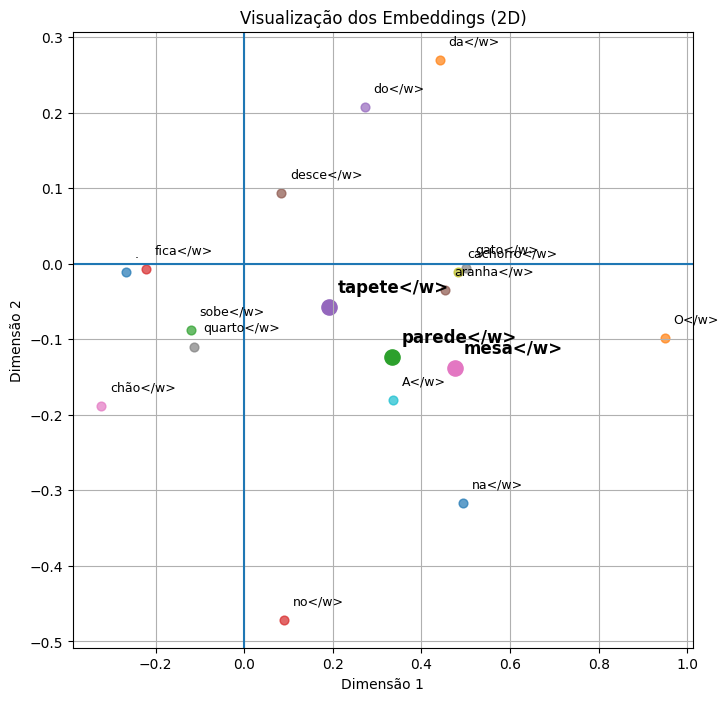

In [16]:
freq = Counter()
for ids in sequencias_ids:
    freq.update(ids)

# Seleciona os tokens mais frequentes para plotar (para não poluir o gráfico)
top_k = 60
ids_top = [i for i, _ in freq.most_common(top_k)]

# Dicionário token -> embedding
embeddings_top = {bpe.id_to_token[i]: modelo.W[i].detach() for i in ids_top}

# Tenta destacar tokens relacionados a conceitos
highlight = []
for termo in ["tapete", "parede", "mesa"]:
    highlight.extend(encontrar_tokens_por_substring(termo, bpe.token_to_id, limite=2))
highlight = list(dict.fromkeys([h for h in highlight if h in embeddings_top]))  # unique e presentes

plot_embeddings(embeddings_top, highlight=highlight)

## 10) (Bônus) Vizinhos mais próximos (cosine) para um token

Para ter uma intuição melhor do embedding aprendido, veremos tokens próximos.


In [17]:
def vizinhos_mais_proximos(
    token: str,
    token_to_id: dict[str, int],
    id_to_token: dict[int, str],
    W: torch.Tensor,
    topn: int = 10,
) -> list[tuple[str, float]]:
    if token not in token_to_id:
        raise KeyError(f"Token {token!r} não está no vocabulário.")

    idx = token_to_id[token]
    v = W[idx].detach()
    Wn = F.normalize(W.detach(), dim=1)
    vn = F.normalize(v, dim=0)

    sims = (Wn @ vn).cpu()
    # remove o próprio token
    sims[idx] = -1.0
    vals, inds = torch.topk(sims, k=topn)

    return [(id_to_token[int(i)], float(vv)) for i, vv in zip(inds, vals)]

# Escolhe um token destacado (se existir)
token_base = "cachorro</w>"
print("Token-base:", token_base)

for tok, sim in vizinhos_mais_proximos(token_base, bpe.token_to_id, bpe.id_to_token, modelo.W, topn=10):
    print(f"{tok:>12s}  sim={sim:.3f}")

Token-base: cachorro</w>
    gato</w>  sim=0.999
  aranha</w>  sim=0.971
    mesa</w>  sim=0.950
  parede</w>  sim=0.932
      da</w>  sim=0.819
       O</w>  sim=0.809
  tapete</w>  sim=0.778
      do</w>  sim=0.774
      na</w>  sim=0.683
       A</w>  sim=0.610
